# Validation Set with Manual Review
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, make_model_output_plot
from analysis_utils.Analysis import  print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa
from zero_one_based_conversion import convert

sns.set_style("white")
sns.set_context('talk')


Using TensorFlow backend.


In [4]:
# Pull in training data
Y = pd.get_dummies(pd.read_pickle('../data/call.pkl'), columns=['a','f','s']).astype(float).values
X = pd.read_pickle('../data/training_data.pkl').sort_index(axis=1).astype(float).values

In [5]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [7]:
estimator.fit(X, Y)

In [8]:
# Analyze predicted labels
label_binarizer = preprocessing.LabelBinarizer()

def determine_independent_test_performance(training_data_path,
                                          calls_path, tumor_type,
                                          cols_to_drop, 
                                          estimator,
                                          test_set_display_name):
    data = pd.read_pickle(training_data_path)
    data['solid_tumor'] = tumor_type
    call = pd.read_pickle(calls_path)
    call=call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
    print(call.value_counts())
    # if the review doesn't contail all calls, add to the the one hot feature matrix
    call_types = ['a', 'f', 's']
    not_in = []
    call_index = 0
    for c in call_types:
        if c not in list(call.unique()):
            not_in.append(call_index)
        call_index+=1

    # Get Labels
    Y = pd.get_dummies(call, columns=call_types).astype(float).values
    if len(not_in)>0:
        for index in not_in:
            Y = np.insert(Y, index, 0, axis=1)
    # Get training data as numpy array
    X = data.sort_index(axis=1).drop(cols_to_drop, axis=1).astype(float).values

    probs = estimator.predict_proba(X)
    fig, ax = plt.subplots()
    create_roc_curve(Y, probs, {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}, 
                     'Receiver Operating Characteristic - '+
                     test_set_display_name+
                     ' - Deep Learning', ax)
    fig, ax = plt.subplots(figsize=(8,6),dpi=100)
    lgd = create_reliability_diagram(probs, Y,
                                     ['Ambiguous','Fail','Somatic'], 
                                     'cornflowerblue', 
                                     'Reliability Diagram - '+
                                     test_set_display_name+
                                     ' - Deep Learning',
                                     ax, True, True, True)
    lgd.set_bbox_to_anchor((0.1, .85))
    fig, ax = plt.subplots(figsize=(8,6),dpi=100)
    make_model_output_plot(probs, 'Deep learning output distributions -'
                           ' '+test_set_display_name+' test set')
#     label_binarizer.fit(range(max(estimator.predict(X))+1))
    predicted_transformed = label_binarizer.fit_transform(estimator.predict(X))
    print('Kappa: ', calculate_kappa(predicted_transformed+Y))
    print('Cohen\'s Kappa: ', metrics.cohen_kappa_score(np.argmax(Y, axis=1), estimator.predict(X)))
    return X, Y, probs

import warnings
warnings.filterwarnings('ignore')

def calculate_retraining_improvement(independent_test_X, independent_test_Y,
                                    X, Y, estimator):
    auc = []
    for i in np.arange(0, 0.8, 0.05):
        if i == 0:
            independent_test_X_test = independent_test_X
            independent_test_Y_test = independent_test_Y
            X_train = X
            Y_train = Y
        else:
            (independent_test_X_train, 
             independent_test_X_test, 
             independent_test_Y_train, 
             independent_test_Y_test) = train_test_split(independent_test_X, 
                                                         independent_test_Y,
                                                         train_size=i,
                                                         random_state=7,
                                                         stratify=\
                                                         independent_test_Y) 
            X_train = np.concatenate((X, independent_test_X_train))
            Y_train = np.concatenate((Y, independent_test_Y_train))
        print('Percentage of test data included in training: ', i*100)
        print('Training data shape: ', X_train.shape)
        print('Test data shape: ', independent_test_X_test.shape)
        print('Number of test samples included in training: ', 
              X_train.shape[0]-X.shape[0])
        estimator.fit(X_train, Y_train)
        X_test_probs = estimator.predict_proba(independent_test_X_test)
        print_accuracy_and_classification_report(independent_test_Y_test, 
                                                 predict_classes(X_test_probs
                                                                )
                                                )
        temp_auc = []
        temp_auc.append(X_train.shape[0]-X.shape[0])
        for j in range(Y.shape[1]):
            try:
                temp_auc.append(metrics.roc_auc_score(
                    independent_test_Y_test[:, j], X_test_probs[:, j]))
            except ValueError:
                temp_auc.append(0)
        auc.append(temp_auc)
        print('Test AUC: ', temp_auc)
        print('---------------------------------------------------------')
    return auc


def create_batch_effect_retraining_figure(auc, fig_out_name):
    auc = pd.DataFrame(auc, columns=['num. variants in training','ambiguous', 'fail','somatic'])
    fig, ax = plt.subplots(1, 1)
    auc.plot(x='num. variants in training', y='somatic', ax=ax, 
                  color='black')
    ax.plot([0, auc['num. variants in training'].max()],
            [.96,.96], linestyle='--', dashes=(5, 5),color='black', 
            label='somatic cross validation')
    auc.plot(x='num. variants in training', y='fail', ax=ax, 
                  color='red')
    ax.plot([0, auc['num. variants in training'].max()], 
            [.99,.99], linestyle='--', dashes=(5, 5),color='red', 
            label='fail cross validation')
    auc.plot(x='num. variants in training', y='ambiguous', ax=ax, 
                  color='darkorange')
    ax.plot([0, auc['num. variants in training'].max()], 
            [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', 
            label='ambiguious cross validation')
    ax.legend(loc=4,frameon=True)
    ax.set_ylim([0,1.0])
    ax.set_ylabel('AUC Attained After Training', fontsize=22)
    ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
    ax.set_title('', fontsize=24)
    fig.set_size_inches(10, 8)
    plt.show()
    fig.savefig(fig_out_name+'.png', bbox_inches='tight', dpi=1000)

# SCLC Validation

s    2526
f     145
a      15
Name: call, dtype: int64
confidence intervals +-:  [ 0.00220558  0.01543868  0.02347689  0.03588659  0.04216214  0.04113935
  0.05314711  0.03411127  0.01485312  0.00278558]
Kappa:  0.271094729257
Cohen's Kappa:  0.275579500003


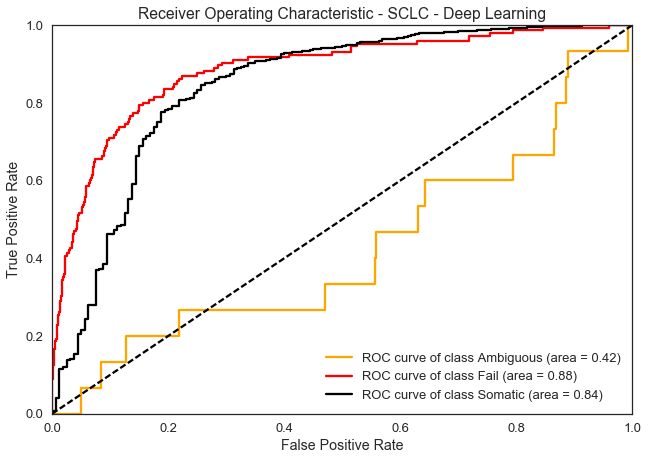

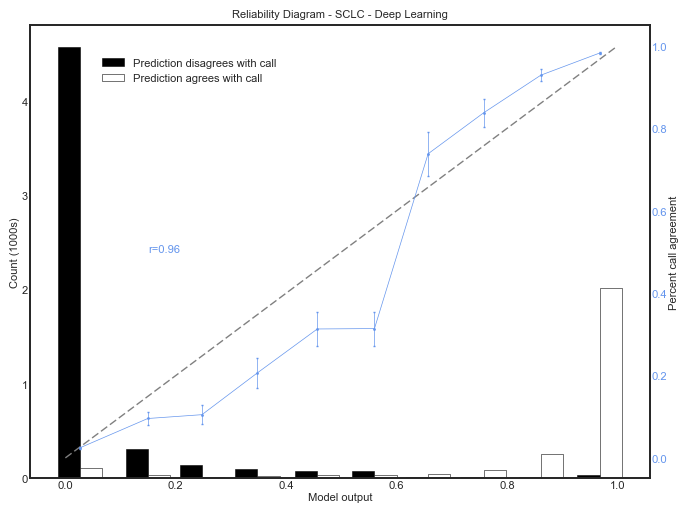

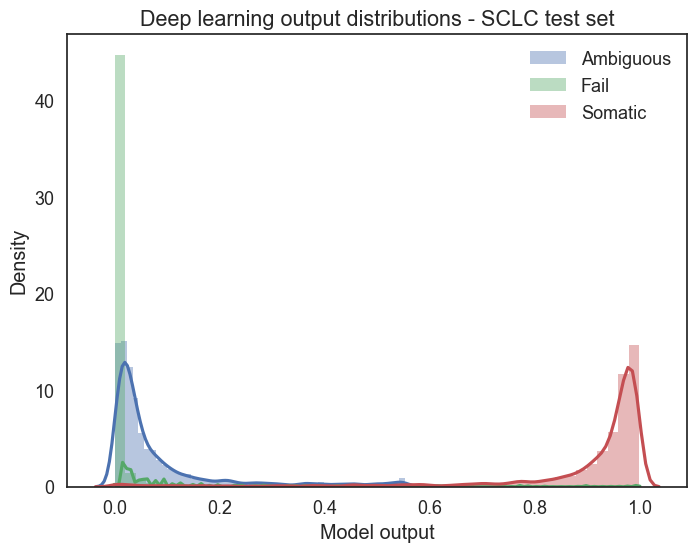

In [9]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
sclc_X, sclc_Y, sclc_probs = determine_independent_test_performance('../data/independent_test/sclc_train.pkl',
                                          '../data/independent_test/sclc_call.pkl', 1,
                                          ['disease_SCLC', 'reviewer_Lee', 'reviewer_Erica'], 
                                          estimator,
                                          "SCLC")

In [10]:
sclc_auc = calculate_retraining_improvement(sclc_X, sclc_Y, X, Y, estimator)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.92442293373

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.70      0.18      0.29       145
          2       0.96      0.97      0.97      2526

avg / total       0.94      0.92      0.92      2686

Test AUC:  [0, 0.4245600898539873, 0.88633310263404308, 0.84470754156769601]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41966, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation accuracy:
	 0.933777429467

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      

Percentage of test data included in training:  65.0
Training data shape:  (43577, 59)
Test data shape:  (941, 59)
Number of test samples included in training:  1745
Cross validation accuracy:
	 0.935175345377

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         5
          1       1.00      0.18      0.30        51
          2       0.96      0.98      0.97       885

avg / total       0.96      0.94      0.93       941

Test AUC:  [1745, 0.46623931623931625, 0.91907909231108176, 0.88044794188861986]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (43712, 59)
Test data shape:  (806, 59)
Number of test samples included in training:  1880
Cross validation accuracy:
	 0.936724565757

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0

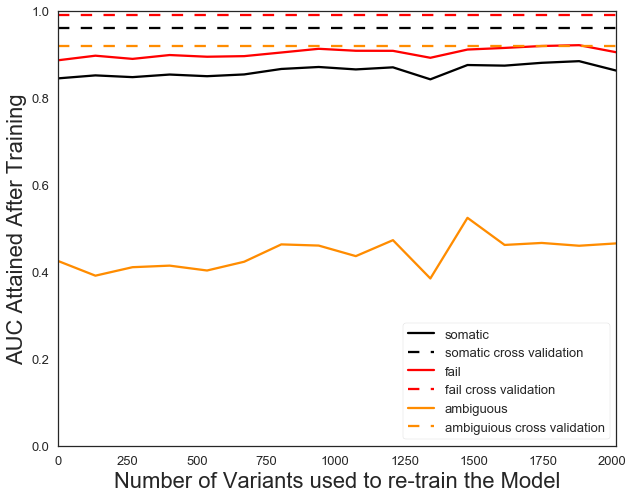

In [11]:
create_batch_effect_retraining_figure(sclc_auc, '../figures/independent_test/sclc')

# Breast Test Set

s    284
a     92
f     67
Name: call, dtype: int64
confidence intervals +-:  [ 0.00946966  0.05350619  0.08125     0.09212884  0.06864575  0.07528972
  0.13876079  0.09046097  0.05955097  0.01960552]
Kappa:  0.263156537492
Cohen's Kappa:  0.300500630378


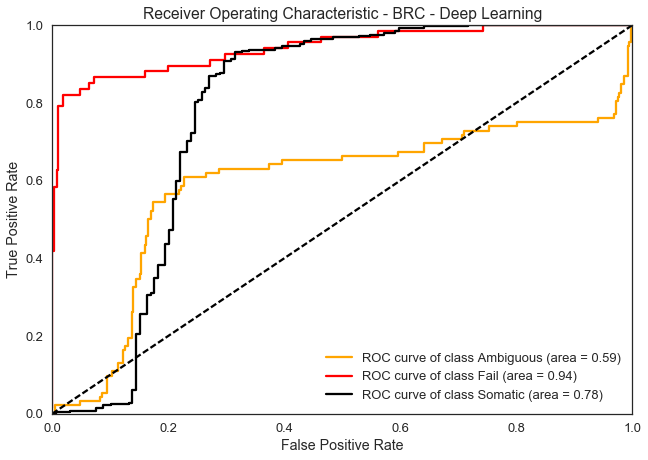

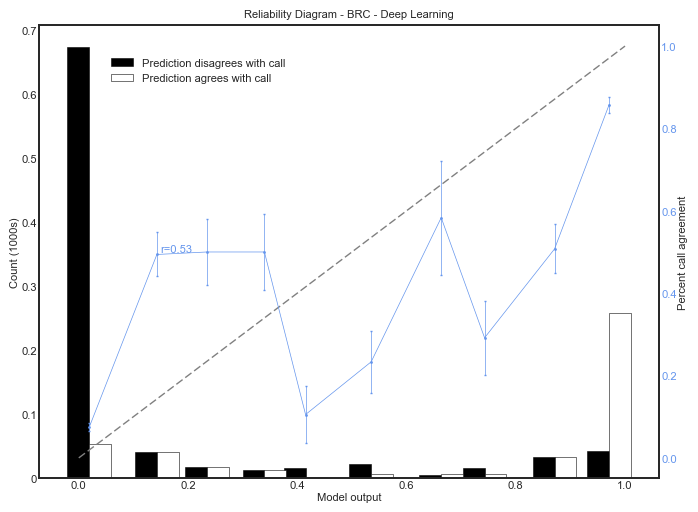

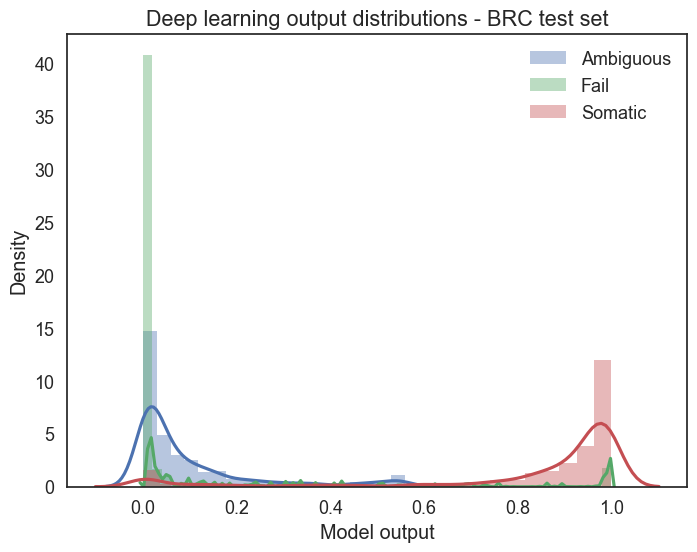

In [12]:
# class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
brc_X, brc_Y, brc_probs = determine_independent_test_performance('../data/independent_test/brc_train.pkl',
                                          '../data/independent_test/brc_call.pkl', 1,
                                          ['disease_BRC', 'reviewer_1'], 
                                          estimator,
                                          "BRC")

In [13]:
brc_auc = calculate_retraining_improvement(brc_X, brc_Y, X, Y, estimator)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (443, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.695259593679

Cross validation classification report

             precision    recall  f1-score   support

          0       0.09      0.01      0.02        92
          1       1.00      0.34      0.51        67
          2       0.69      1.00      0.82       284

avg / total       0.62      0.70      0.61       443

Test AUC:  [0, 0.6055060076799208, 0.92854874563353451, 0.78886526707414295]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41854, 59)
Test data shape:  (421, 59)
Number of test samples included in training:  22
Cross validation accuracy:
	 0.700712589074

Cross validation classification report

             precision    recall  f1-score   support

          0       0.12      0.02      0.04        

Cross validation accuracy:
	 0.711538461538

Cross validation classification report

             precision    recall  f1-score   support

          0       0.20      0.06      0.10        32
          1       1.00      0.38      0.55        24
          2       0.73      1.00      0.84       100

avg / total       0.66      0.71      0.64       156

Test AUC:  [287, 0.64742943548387089, 0.94602272727272729, 0.81964285714285712]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (42142, 59)
Test data shape:  (133, 59)
Number of test samples included in training:  310
Cross validation accuracy:
	 0.744360902256

Cross validation classification report

             precision    recall  f1-score   support

          0       0.47      0.25      0.33        28
          1       1.00      0.35      0.52        20
          2       0.77      1.00      0.87        85

avg / total       0.74      0.74      0.70    

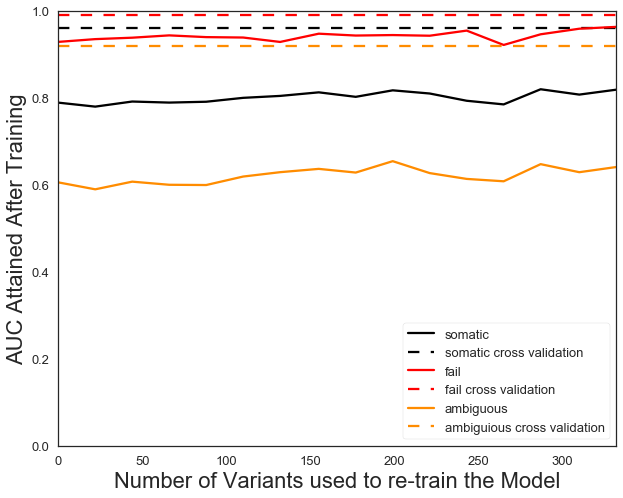

In [14]:
create_batch_effect_retraining_figure(brc_auc, '../figures/independent_test/BRC_batch')

# Folicular Lymphoma

s    865
f    858
Name: call, dtype: int64
confidence intervals +-:  [ 0.00899055  0.00911916  0.02156906  0.03937107  0.04508004  0.03145894
  0.05863261  0.03573413  0.01889673  0.01388058]
Kappa:  -0.0905770468148
Cohen's Kappa:  0.106309600786


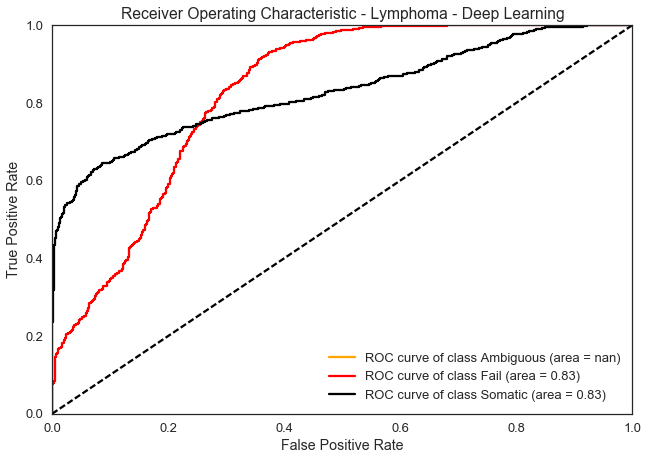

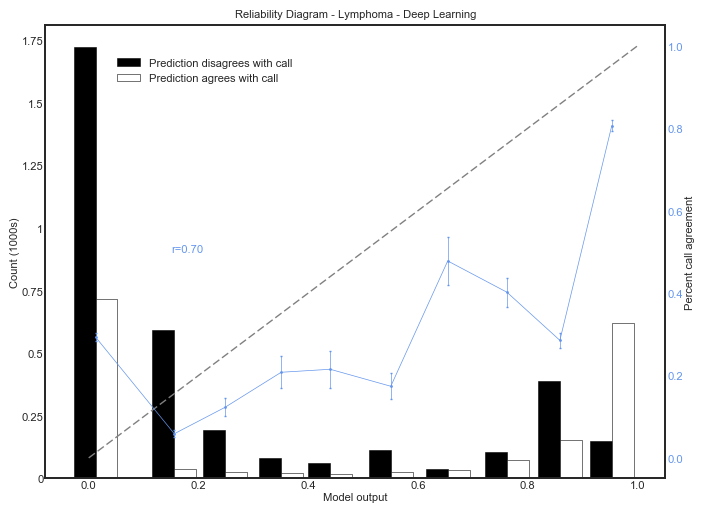

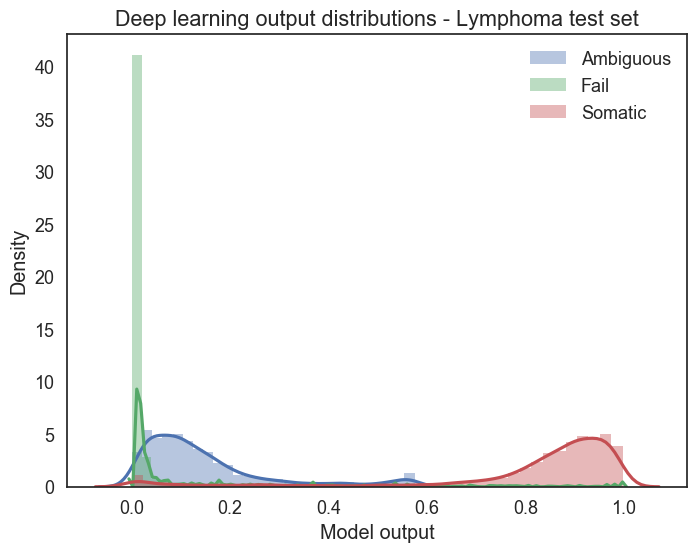

In [15]:
fl_X, fl_Y, fl_probs = determine_independent_test_performance('../data/independent_test/fl_train.pkl',
                                          '../data/independent_test/fl_call.pkl', 1,
                                          ['disease_FL', 'reviewer_NA'], 
                                          estimator,
                                          "Lymphoma")

In [16]:
fl_auc = calculate_retraining_improvement(fl_X, fl_Y, X, Y, estimator)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (1723, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.514799767847

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.03      0.06       858
          2       0.54      0.99      0.70       865

avg / total       0.77      0.51      0.38      1723

Test AUC:  [0, 0, 0.89466699004271266, 0.89466699004271266]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41918, 59)
Test data shape:  (1637, 59)
Number of test samples included in training:  86
Cross validation accuracy:
	 0.524740378742

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1 

Percentage of test data included in training:  65.0
Training data shape:  (42951, 59)
Test data shape:  (604, 59)
Number of test samples included in training:  1119
Cross validation accuracy:
	 0.53642384106

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.98      0.14      0.24       301
          2       0.65      0.93      0.76       303

avg / total       0.81      0.54      0.51       604

Test AUC:  [1119, 0, 0.91490411499621715, 0.91490411499621715]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (43038, 59)
Test data shape:  (517, 59)
Number of test samples included in training:  1206
Cross validation accuracy:
	 0.52998065764

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
      

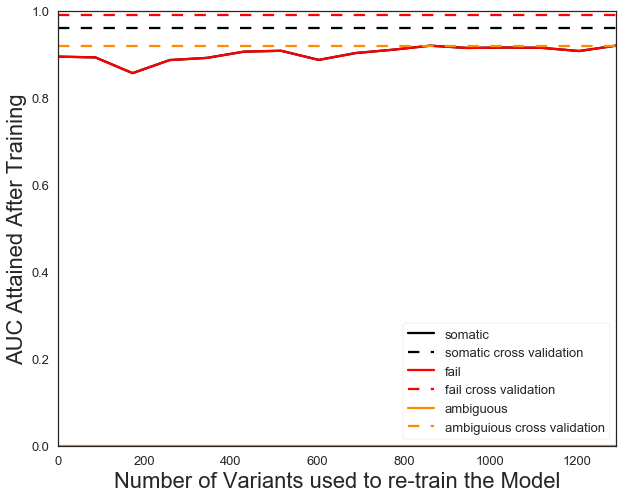

In [17]:
create_batch_effect_retraining_figure(fl_auc, '../figures/independent_test/FL_batch')

# OSCC

f    6891
s    1986
a     293
Name: call, dtype: int64
confidence intervals +-:  [ 0.00405913  0.00918402  0.01081932  0.00681486  0.00487999  0.00820938
  0.01726903  0.01822197  0.00962368  0.00569493]
Kappa:  0.108892435574
Cohen's Kappa:  0.191584469861


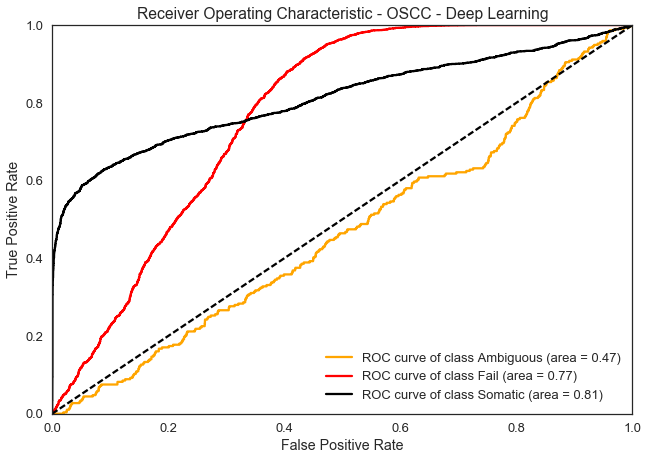

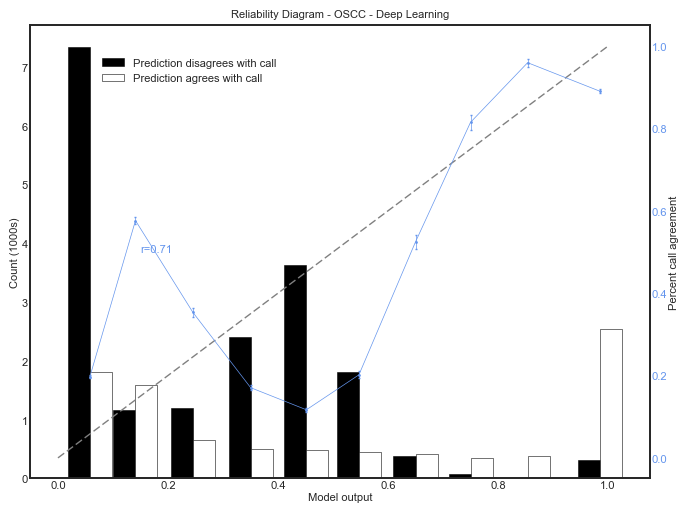

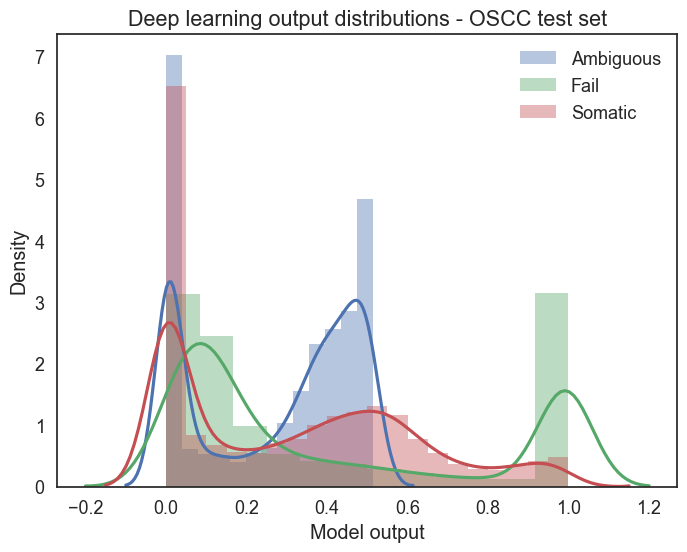

In [18]:
oscc_X, oscc_Y, oscc_probs = determine_independent_test_performance('../data/independent_test/oscc_train.pkl',
                                          '../data/independent_test/oscc_call.pkl', 1,
                                          ['disease_OSCC', 'reviewer_NA'], 
                                          estimator,
                                          "OSCC")

In [20]:
oscc_auc = calculate_retraining_improvement(oscc_X, oscc_Y, X, Y, estimator)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (9170, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.437840785169

Cross validation classification report

             precision    recall  f1-score   support

          0       0.04      0.12      0.05       293
          1       0.87      0.33      0.48      6891
          2       0.30      0.84      0.45      1986

avg / total       0.72      0.44      0.46      9170

Test AUC:  [0, 0.4755127047272143, 0.75875882520707794, 0.79646458954328414]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (42290, 59)
Test data shape:  (8712, 59)
Number of test samples included in training:  458
Cross validation accuracy:
	 0.45121671258

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.18      0.05      

Percentage of test data included in training:  65.0
Training data shape:  (47792, 59)
Test data shape:  (3210, 59)
Number of test samples included in training:  5960
Cross validation accuracy:
	 0.73800623053

Cross validation classification report

             precision    recall  f1-score   support

          0       0.02      0.13      0.04       103
          1       0.89      0.83      0.86      2412
          2       0.93      0.51      0.66       695

avg / total       0.87      0.74      0.79      3210

Test AUC:  [5960, 0.41680077244930797, 0.80038352514786137, 0.84987342134244881]
---------------------------------------------------------
Percentage of test data included in training:  70.0
Training data shape:  (48251, 59)
Test data shape:  (2751, 59)
Number of test samples included in training:  6419
Cross validation accuracy:
	 0.74445656125

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.16      0

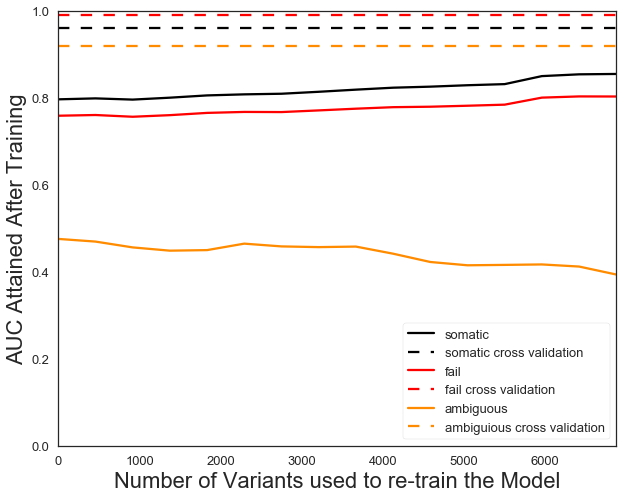

In [21]:
create_batch_effect_retraining_figure(oscc_auc, '../figures/independent_test/OSCC_batch')